## Introduction

In this notebook, we want to raise these questions:

1) Who are the landlords that conducted most evictions over the years 2017 - 2024? \
2) Are they individual landlords or corporate landlords? What are their background? \

One hypothesis that can be tested in this notebook is: \

1) The landlords who conducted most evcitions are corporate landlords, as opposed to individuals. \



BBL Data explainations:
https://data.cityofnewyork.us/City-Government/Primary-Land-Use-Tax-Lot-Output-PLUTO-/64uk-42ks/about_data

A very detailed NYC building info data: https://s-media.nyc.gov/agencies/dcp/assets/files/pdf/data-tools/bytes/padgui.pdf

Some other info: https://www.nyc.gov/assets/finance/jump/hlpbldgcode.html


In [2]:
# !pip install geopandas folium matplotlib seaborn scipy
# !pip install esda
# !pip install splot
# # for google colab, had to reinstall some pacakges.

In [ ]:
# !pip install geopandas folium matplotlib seaborn scipy esda splot

In [3]:
import pandas as pd
import geopandas as gpd
import numpy as np
import datetime as dt
import scipy

from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

# visualization
import matplotlib.pyplot as plt
from matplotlib import colors as mcolors
import seaborn as sns
import folium
from folium.plugins import HeatMap
from folium import Marker
from folium.plugins import MarkerCluster
import plotly.express as px
import plotly.io as pio

# spatial statistics
from esda.moran import Moran
from esda import Moran_Local
from esda.getisord import G_Local
from shapely.geometry import Point
from libpysal.weights import Queen, Rook

# system and utility
import warnings
import os
import io
from IPython.display import IFrame
from google.colab import files

from libpysal.weights import Queen, Rook
from esda.moran import Moran
import matplotlib.pyplot as plt
from splot.esda import moran_scatterplot

# suppress warnings
warnings.filterwarnings('ignore')

# inline
%matplotlib inline

# Part 1: Get the Evictions data

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# data source:
# gdf already cleaned with lisa info
file_path = '/content/drive/My Drive/X999/evictions_cleaned_lisa.csv'

In [6]:
evictions_cleaned_raw = pd.read_csv(file_path)

In [7]:
evictions_cleaned = evictions_cleaned_raw.copy()

In [8]:
evictions_cleaned.head(1) # only show one row to save space

,court_index_number,docket_number,eviction_address,eviction_apartment_number,executed_date,borough,eviction_postcode,ejectment,eviction/legal_possession,latitude,...,eviction_count,year,average_year_eviction_count,cluster,cluster_k,same_cluster,lisa_cluster_rook,lisa_pvalue_rook,lisa_cluster_queen,lisa_pvalue_queen
0,*313639/23,5202,710 61ST STREET,2ND FLOOR,2024-03-04,BROOKLYN,11220,Not an Ejectment,Possession,40.635941,...,3,2024,3.0,0,0,True,4,0.241,4,0.24


In [9]:
evictions_cleaned.columns

Index(['court_index_number', 'docket_number', 'eviction_address',
       'eviction_apartment_number', 'executed_date', 'borough',
       'eviction_postcode', 'ejectment', 'eviction/legal_possession',
       'latitude', 'longitude', 'community_board', 'council_district',
       'census_tract', 'bin', 'bbl', 'nta', 'geometry', 'eviction_count',
       'year', 'average_year_eviction_count', 'cluster', 'cluster_k',
       'same_cluster', 'lisa_cluster_rook', 'lisa_pvalue_rook',
       'lisa_cluster_queen', 'lisa_pvalue_queen'],
      dtype='object')

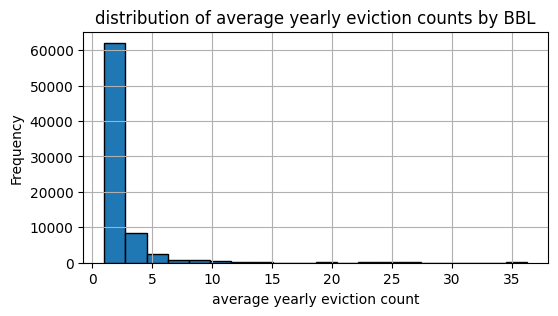

In [10]:
# check out the distribution of average yearly eviction counts by bbl
plt.figure(figsize=(6,3))
plt.hist(evictions_cleaned['average_year_eviction_count'], bins=20, edgecolor='black')
plt.title('distribution of average yearly eviction counts by BBL')
plt.xlabel('average yearly eviction count')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [11]:
evictions_cleaned['average_year_eviction_count'].describe()

,average_year_eviction_count
count,76484.000000
mean,2.401864
std,3.468042
min,1.000000
25%,1.000000
50%,1.500000
75%,2.250000
max,36.285714


#### short summary:

It is obvious that only a handful of buildings have a dispropotionally large amount of evictions.

In [12]:
top_bbls = evictions_cleaned[['bbl', 'average_year_eviction_count']].groupby('bbl').mean().sort_values(by='average_year_eviction_count', ascending=False)
top_bbls.shape

(34032, 1)

In [13]:
top_bbls.head(1)

,average_year_eviction_count
bbl,
2.028820e+09,36.285714


In [14]:
bbls_over_10_evictions = top_bbls[top_bbls['average_year_eviction_count'] >= 10]
bbls_over_10_evictions.shape, \
bbls_over_10_evictions.columns

((20, 1), Index(['average_year_eviction_count'], dtype='object'))

In [15]:
bbls_over_10_evictions_reset = bbls_over_10_evictions.reset_index()
bbls_over_10_evictions_reset.head(1)

,bbl,average_year_eviction_count
0,2.028820e+09,36.285714


In [16]:
bbls_over_10_evictions_reset.bbl = bbls_over_10_evictions_reset.bbl.astype(int)
bbls_over_10_evictions_reset.head(1)

,bbl,average_year_eviction_count
0,2028820229,36.285714


# Part 2: Get the BBL data

In [17]:
# data source:
# bbl
file_path = '/content/drive/My Drive/X999/BBL.csv'

In [18]:
bbl_df = pd.read_csv(file_path)

In [19]:
bbl_df.shape, \
bbl_df.bbl

((858189, 99),
 0         2025870022
 1         1001350014
 2         3070870005
 3         4029300010
 4         1007360022
              ...    
 858184    4102700247
 858185    4102800032
 858186    3063630007
 858187    3063630008
 858188    3037630102
 Name: bbl, Length: 858189, dtype: int64)

In [28]:
bbl_list = bbl_df['bbl'].tolist()
top_evictions_list = bbls_over_10_evictions_reset['bbl'].tolist()

In [29]:
# lists to sets and find the intersection
overlap = set(bbl_list).intersection(set(top_evictions_list))
overlap_list = list(overlap)
overlap_list[:2], \
len(overlap_list)
# so, we will examine the 19 buildings that have the most evictions.

([1017600001, 2028820229], 19)

In [30]:
top_20 = bbls_over_10_evictions_reset[bbls_over_10_evictions_reset['bbl'].isin(overlap)]
top_20

,bbl,average_year_eviction_count
0,2028820229,36.285714
1,2051410120,27.428571
2,4124950002,25.428571
3,4159260001,23.000000
4,2039447501,22.714286
5,2039437501,18.714286
6,2049050001,16.333333
8,1003560001,14.333333
9,3036280001,13.714286
10,4156100001,12.857143


In [31]:
bbl_df.head(1)

,borough,block,lot,community board,census tract 2010,cb2010,schooldist,council district,postcode,firecomp,...,dcasdate,zoningdate,landmkdate,basempdate,masdate,polidate,edesigdate,geom,dcpedited,notes
0,BX,2587,22,201.0,19.0,3026.0,7.0,17.0,10454.0,L029,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [32]:
top_20.columns

Index(['bbl', 'average_year_eviction_count'], dtype='object')

In [33]:
bbl_df['bbl'][0].dtype, len(bbl_df['bbl']), top_20.bbl[0].dtype # great, cleaned

(dtype('int64'), 858189, dtype('int64'))

In [34]:
# top_20_bbls_index = top_20_bbls.index
top_20_merged = bbl_df[bbl_df['bbl'].isin(top_20.bbl)]
top_20_merged.bbl[:2], \
top_20_merged.shape

(483     2039387501
 1590    2055297502
 Name: bbl, dtype: int64,
 (19, 99))

In [35]:
top_20_merged.columns

Index(['borough', 'block', 'lot', 'community board', 'census tract 2010',
       'cb2010', 'schooldist', 'council district', 'postcode', 'firecomp',
       'policeprct', 'healtharea', 'sanitboro', 'sanitsub', 'address',
       'zonedist1', 'zonedist2', 'zonedist3', 'zonedist4', 'overlay1',
       'overlay2', 'spdist1', 'spdist2', 'spdist3', 'ltdheight', 'splitzone',
       'bldgclass', 'landuse', 'easements', 'ownertype', 'ownername',
       'lotarea', 'bldgarea', 'comarea', 'resarea', 'officearea', 'retailarea',
       'garagearea', 'strgearea', 'factryarea', 'otherarea', 'areasource',
       'numbldgs', 'numfloors', 'unitsres', 'unitstotal', 'lotfront',
       'lotdepth', 'bldgfront', 'bldgdepth', 'ext', 'proxcode', 'irrlotcode',
       'lottype', 'bsmtcode', 'assessland', 'assesstot', 'exempttot',
       'yearbuilt', 'yearalter1', 'yearalter2', 'histdist', 'landmark',
       'builtfar', 'residfar', 'commfar', 'facilfar', 'borocode', 'bbl',
       'condono', 'tract2010', 'xcoord', 'y

In [36]:
top_20_merged.head(1)

,borough,block,lot,community board,census tract 2010,cb2010,schooldist,council district,postcode,firecomp,...,dcasdate,zoningdate,landmkdate,basempdate,masdate,polidate,edesigdate,geom,dcpedited,notes
483,BX,3938,7501,209.0,212.0,2001.0,11.0,18.0,10462.0,E064,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [38]:
# only keep the relevant columns that may answer the questions or help vis
columns_to_keep = [
    'borough', 'block', 'lot', 'community board', 'census tract 2010',
    'ownername', 'ownertype', 'lotarea', 'bldgarea', 'numbldgs', 'numfloors',
    'unitsres', 'unitstotal', 'assessland', 'assesstot', 'landuse', 'bbl',
    'yearbuilt', 'latitude', 'longitude', 'zonedist1', 'zonedist2', 'postcode'
]
top_20_merged_cleaned = top_20_merged[columns_to_keep]
top_20_merged_cleaned.head()

,borough,block,lot,community board,census tract 2010,ownername,ownertype,lotarea,bldgarea,numbldgs,...,assessland,assesstot,landuse,bbl,yearbuilt,latitude,longitude,zonedist1,zonedist2,postcode
483,BX,3938,7501,209.0,212.00,PARKCHESTER SOUTH CONDOMINIUM ASSOC,NaN,951289.0,2199075.0,39.0,...,1895777.0,101777525.0,4.0,2039387501,0.0,40.836109,-73.858934,R6,C4-2,10462.0
1590,BX,5529,7502,210.0,118.00,UNAVAILABLE OWNER,NaN,54000.0,49511.0,17.0,...,122861.0,1745114.0,2.0,2055297502,1998.0,40.809745,-73.801936,R3-1,NaN,10465.0
66632,BX,5141,120,210.0,462.01,RIVERBAY CORPORATION,X,5048550.0,13540113.0,250.0,...,25285500.0,218048850.0,3.0,2051410120,1969.0,40.875013,-73.828362,R6,NaN,10475.0
155329,BX,4506,1,211.0,336.00,BPE REALTY OWNER LLC,NaN,208366.0,282920.0,4.0,...,1062900.0,6357600.0,4.0,2045060001,1927.0,40.866015,-73.869753,R7-1,NaN,10467.0
199000,BK,4981,1,317.0,782.00,RENAISSANCE EQUITY HOLDINGS LLC E,NaN,138745.0,324000.0,10.0,...,1080000.0,9847350.0,3.0,3049810001,1950.0,40.638146,-73.944581,R6,NaN,11210.0


In [39]:
top_20['bbl'] = top_20['bbl'].astype(int)
top_20_merged_cleaned['bbl'] = top_20_merged_cleaned['bbl'].astype(int)
merged_df = pd.merge(top_20, top_20_merged_cleaned, how='inner', on='bbl')
# a good rule of thumb is to use inner here to only match bbl values that are included.

In [40]:
merged_df.columns, evictions_cleaned.columns

(Index(['bbl', 'average_year_eviction_count', 'borough', 'block', 'lot',
        'community board', 'census tract 2010', 'ownername', 'ownertype',
        'lotarea', 'bldgarea', 'numbldgs', 'numfloors', 'unitsres',
        'unitstotal', 'assessland', 'assesstot', 'landuse', 'yearbuilt',
        'latitude', 'longitude', 'zonedist1', 'zonedist2', 'postcode'],
       dtype='object'),
 Index(['court_index_number', 'docket_number', 'eviction_address',
        'eviction_apartment_number', 'executed_date', 'borough',
        'eviction_postcode', 'ejectment', 'eviction/legal_possession',
        'latitude', 'longitude', 'community_board', 'council_district',
        'census_tract', 'bin', 'bbl', 'nta', 'geometry', 'eviction_count',
        'year', 'average_year_eviction_count', 'cluster', 'cluster_k',
        'same_cluster', 'lisa_cluster_rook', 'lisa_pvalue_rook',
        'lisa_cluster_queen', 'lisa_pvalue_queen'],
       dtype='object'))

In [41]:
# merge based on the 'bbl' column
# add back the nta from evictions_cleaned
merged_df = merged_df.merge(evictions_cleaned[['bbl', 'nta']], on='bbl', how='left')
merged_df.columns

Index(['bbl', 'average_year_eviction_count', 'borough', 'block', 'lot',
       'community board', 'census tract 2010', 'ownername', 'ownertype',
       'lotarea', 'bldgarea', 'numbldgs', 'numfloors', 'unitsres',
       'unitstotal', 'assessland', 'assesstot', 'landuse', 'yearbuilt',
       'latitude', 'longitude', 'zonedist1', 'zonedist2', 'postcode', 'nta'],
      dtype='object')

In [42]:
merged_df.shape, \
merged_df.columns

((1895, 25),
 Index(['bbl', 'average_year_eviction_count', 'borough', 'block', 'lot',
        'community board', 'census tract 2010', 'ownername', 'ownertype',
        'lotarea', 'bldgarea', 'numbldgs', 'numfloors', 'unitsres',
        'unitstotal', 'assessland', 'assesstot', 'landuse', 'yearbuilt',
        'latitude', 'longitude', 'zonedist1', 'zonedist2', 'postcode', 'nta'],
       dtype='object'))

In [ ]:
# merged_df.average_year_eviction_count

In [43]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1895 entries, 0 to 1894
Data columns (total 25 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   bbl                          1895 non-null   int64  
 1   average_year_eviction_count  1895 non-null   float64
 2   borough                      1895 non-null   object 
 3   block                        1895 non-null   int64  
 4   lot                          1895 non-null   int64  
 5   community board              1895 non-null   float64
 6   census tract 2010            1895 non-null   float64
 7   ownername                    1895 non-null   object 
 8   ownertype                    1151 non-null   object 
 9   lotarea                      1895 non-null   float64
 10  bldgarea                     1895 non-null   float64
 11  numbldgs                     1895 non-null   float64
 12  numfloors                    1895 non-null   float64
 13  unitsres          

In [45]:
merged_df.head()

,bbl,average_year_eviction_count,borough,block,lot,community board,census tract 2010,ownername,ownertype,lotarea,...,assessland,assesstot,landuse,yearbuilt,latitude,longitude,zonedist1,zonedist2,postcode,nta
0,2028820229,36.285714,BX,2882,229,205.0,53.0,"RIVER PARK BRONX APARTMENTS, INC.",X,856800.0,...,11566800.0,55282050.0,4.0,1973.0,40.85187,-73.922649,M2-1,NaN,10453.0,University Heights-Morris Heights
1,2028820229,36.285714,BX,2882,229,205.0,53.0,"RIVER PARK BRONX APARTMENTS, INC.",X,856800.0,...,11566800.0,55282050.0,4.0,1973.0,40.85187,-73.922649,M2-1,NaN,10453.0,University Heights-Morris Heights
2,2028820229,36.285714,BX,2882,229,205.0,53.0,"RIVER PARK BRONX APARTMENTS, INC.",X,856800.0,...,11566800.0,55282050.0,4.0,1973.0,40.85187,-73.922649,M2-1,NaN,10453.0,University Heights-Morris Heights
3,2028820229,36.285714,BX,2882,229,205.0,53.0,"RIVER PARK BRONX APARTMENTS, INC.",X,856800.0,...,11566800.0,55282050.0,4.0,1973.0,40.85187,-73.922649,M2-1,NaN,10453.0,University Heights-Morris Heights
4,2028820229,36.285714,BX,2882,229,205.0,53.0,"RIVER PARK BRONX APARTMENTS, INC.",X,856800.0,...,11566800.0,55282050.0,4.0,1973.0,40.85187,-73.922649,M2-1,NaN,10453.0,University Heights-Morris Heights


In [46]:
# save cleaned evictions data to my drive
merged_df.to_csv('/content/drive/My Drive/X999/top_evictions_bbl_merged_df.csv', index=False)

# Part 3: Analyze the distribution of evictions by landuse to see which type of property experiences the most evictions.

### groupby bbl, nta, borough, landuse, and the average_year_eviction_count

In [47]:
# to get borough, bbl, landuse, as groups and average_year_eviction_count as another column
evictions_by_bbl_landuse_borough = merged_df.groupby(['borough', 'bbl', 'nta', 'landuse']).agg({
    'average_year_eviction_count': 'mean'
}).reset_index()
evictions_by_bbl_landuse_borough

,borough,bbl,nta,landuse,average_year_eviction_count
0,BK,3036280001,Brownsville,3.0,13.714286
1,BK,3049810001,East Flatbush-Farragut,3.0,10.428571
2,BX,2026100012,Claremont-Bathgate,4.0,11.250000
3,BX,2026187501,Melrose South-Mott Haven North,4.0,10.857143
4,BX,2028820229,University Heights-Morris Heights,4.0,36.285714
5,BX,2039387501,Parkchester,4.0,10.857143
6,BX,2039437501,Parkchester,3.0,18.714286
7,BX,2039447501,Parkchester,3.0,22.714286
8,BX,2045060001,Bronxdale,4.0,12.142857
9,BX,2045060040,Bronxdale,2.0,12.714286


In [48]:
evictions_by_landuse = merged_df.groupby('landuse').size().reset_index(name='eviction_count')
evictions_by_landuse

,landuse,eviction_count
0,2.0,99
1,3.0,1260
2,4.0,536


### What do these numbers mean?:

List of values\
Value 01
Description One & Two Family Buildings |
Value 02
Description Multi - Family Walk- Up Buldings |
Value 03
Description Multi - Family Elevator Buildings |
Value 04
Description Mixed Residential and Commercial Buildings |
Value 05
Description Commercial and Office Buildings |
Value 06
Description Industrial and Manufacturing |
Value 07
Description Transportation and Utility |
Value 08
Description Public Facilities and Institutions |
Value 09
Description Open Space and Outdoor Recreation |
Value 10
Description Parking Facilities |
Value 11
Description Vacant Land \

source: https://s-media.nyc.gov/agencies/dcp/assets/files/pdf/data-tools/bytes/meta_mappluto.pdf
Page 34

In [49]:
# a mapping for landuse codes
landuse_mapping = {
    1: 'One & Two Family Buildings',
    2: 'Multi-Family Walk-UP Buildings',
    3: 'Multi-Family Elevator Buildings',
    4: 'Mixed Residential and Commercial Buildings',
    5: 'Commercial and Office Buildings',
    6: 'Industrial and Manufacturing',
    7: 'Transportation & Utility',
    8: 'Public Facilities and Institutions',
    9: 'Open Space and Outdoor Recreation',
    10: 'Parking Facilities',
    11: 'Vacant Land'
}
# evictions_by_bbl_landuse_borough

evictions_by_bbl_landuse_borough['landuse'] = evictions_by_bbl_landuse_borough['landuse'].map(landuse_mapping)

In [50]:
evictions_by_bbl_landuse_borough

,borough,bbl,nta,landuse,average_year_eviction_count
0,BK,3036280001,Brownsville,Multi-Family Elevator Buildings,13.714286
1,BK,3049810001,East Flatbush-Farragut,Multi-Family Elevator Buildings,10.428571
2,BX,2026100012,Claremont-Bathgate,Mixed Residential and Commercial Buildings,11.250000
3,BX,2026187501,Melrose South-Mott Haven North,Mixed Residential and Commercial Buildings,10.857143
4,BX,2028820229,University Heights-Morris Heights,Mixed Residential and Commercial Buildings,36.285714
5,BX,2039387501,Parkchester,Mixed Residential and Commercial Buildings,10.857143
6,BX,2039437501,Parkchester,Multi-Family Elevator Buildings,18.714286
7,BX,2039447501,Parkchester,Multi-Family Elevator Buildings,22.714286
8,BX,2045060001,Bronxdale,Mixed Residential and Commercial Buildings,12.142857
9,BX,2045060040,Bronxdale,Multi-Family Walk-UP Buildings,12.714286


In [51]:
# pivot
evictions_pivot = evictions_by_bbl_landuse_borough.pivot_table(index='borough',
                                                 columns='landuse',
                                                 values='bbl',
                                                 aggfunc='count',
                                                 fill_value=0).reset_index()
average_eviction = evictions_by_bbl_landuse_borough.groupby('borough')['average_year_eviction_count'].mean().reset_index()
evictions_by_borough = pd.merge(evictions_pivot, average_eviction, on='borough')

In [52]:
evictions_by_borough

,borough,Mixed Residential and Commercial Buildings,Multi-Family Elevator Buildings,Multi-Family Walk-UP Buildings,average_year_eviction_count
0,BK,0,2,0,12.071429
1,BX,5,4,2,17.208874
2,MN,0,2,0,12.166667
3,QN,0,3,0,20.428571
4,SI,0,1,0,10.166667


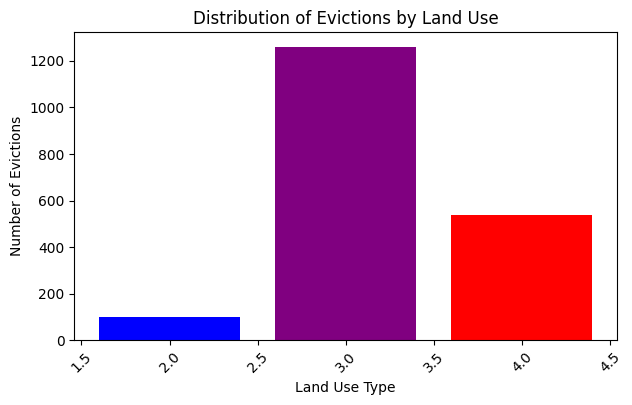

In [53]:
# bar chart
colors = ['blue', 'purple', 'red']
bar_colors = colors * (len(evictions_by_landuse) // len(colors)) + colors[:len(evictions_by_landuse) % len(colors)]
plt.figure(figsize=(7, 4))
plt.bar(evictions_by_landuse['landuse'], evictions_by_landuse['eviction_count'], color=bar_colors)
plt.title('Distribution of Evictions by Land Use')
plt.xlabel('Land Use Type')
plt.ylabel('Number of Evictions')
plt.xticks(rotation=45)
plt.show()

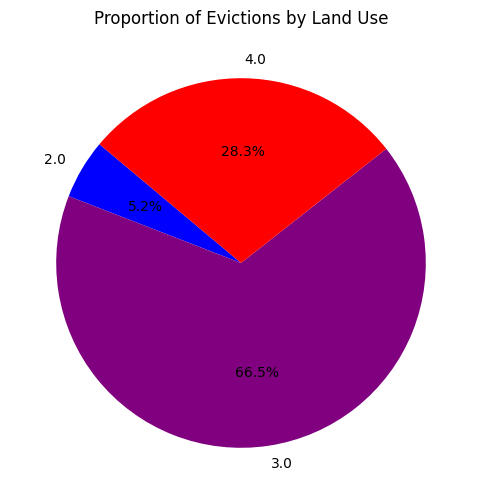

In [54]:
# pie chart
colors = ['blue', 'purple', 'red']
plt.figure(figsize=(6, 6))
plt.pie(evictions_by_landuse['eviction_count'], labels=evictions_by_landuse['landuse'], autopct='%1.1f%%', startangle=140, colors=colors)
plt.title('Proportion of Evictions by Land Use')
plt.show()

# Move Part 4 to the bottom, because the images do not show

# Part 5 Landlord Analysis

Analyze eviction rates by ownername and ownertype to identify landlords with the highest eviction counts.

In [55]:
merged_df.head()

,bbl,average_year_eviction_count,borough,block,lot,community board,census tract 2010,ownername,ownertype,lotarea,...,assessland,assesstot,landuse,yearbuilt,latitude,longitude,zonedist1,zonedist2,postcode,nta
0,2028820229,36.285714,BX,2882,229,205.0,53.0,"RIVER PARK BRONX APARTMENTS, INC.",X,856800.0,...,11566800.0,55282050.0,4.0,1973.0,40.85187,-73.922649,M2-1,NaN,10453.0,University Heights-Morris Heights
1,2028820229,36.285714,BX,2882,229,205.0,53.0,"RIVER PARK BRONX APARTMENTS, INC.",X,856800.0,...,11566800.0,55282050.0,4.0,1973.0,40.85187,-73.922649,M2-1,NaN,10453.0,University Heights-Morris Heights
2,2028820229,36.285714,BX,2882,229,205.0,53.0,"RIVER PARK BRONX APARTMENTS, INC.",X,856800.0,...,11566800.0,55282050.0,4.0,1973.0,40.85187,-73.922649,M2-1,NaN,10453.0,University Heights-Morris Heights
3,2028820229,36.285714,BX,2882,229,205.0,53.0,"RIVER PARK BRONX APARTMENTS, INC.",X,856800.0,...,11566800.0,55282050.0,4.0,1973.0,40.85187,-73.922649,M2-1,NaN,10453.0,University Heights-Morris Heights
4,2028820229,36.285714,BX,2882,229,205.0,53.0,"RIVER PARK BRONX APARTMENTS, INC.",X,856800.0,...,11566800.0,55282050.0,4.0,1973.0,40.85187,-73.922649,M2-1,NaN,10453.0,University Heights-Morris Heights


In [56]:
# merged_df.ownername, \
merged_df.shape

(1895, 25)

In [57]:
merged_df.ownername.unique(), \
len(merged_df.ownername.unique())

(array(['RIVER PARK BRONX APARTMENTS, INC.', 'RIVERBAY CORPORATION',
        'ROCHDALE VILLAGE INC', 'HP ARVERNE PRESERVATION HOUSING COMPANY',
        'PPC RESIDENTIAL, LLC', 'PARKCHESTER SOUTH CONDOMINIUM ASSOC',
        'NYC HOUSING AUTHORITY', 'PLAZA RESIDENCES, LP',
        'HP SEA GIRT HOUSING DEV FUND COMPANY, IN C',
        'BPE REALTY OWNER LLC', 'FORDHAM FULTON REALTY, CORP.',
        'UNAVAILABLE OWNER', 'RENAISSANCE EQUITY HOLDINGS LLC E',
        'NORTH SHORE HOUSES PRESERVATION, INC.',
        'RIVERTON SQUARE HOUSING DEVELOPMENT FUND  CORPORATI'],
       dtype=object),
 15)

In [58]:
evictions_by_landlord = merged_df.groupby(['ownername']).size().reset_index(name='building_count')

In [59]:
evictions_by_landlord_sorted = evictions_by_landlord.sort_values(by='building_count', ascending=False)
evictions_by_landlord_sorted

,ownername,building_count
10,"RIVER PARK BRONX APARTMENTS, INC.",254
6,PARKCHESTER SOUTH CONDOMINIUM ASSOC,207
11,RIVERBAY CORPORATION,192
13,ROCHDALE VILLAGE INC,178
0,BPE REALTY OWNER LLC,174
8,"PPC RESIDENTIAL, LLC",159
2,HP ARVERNE PRESERVATION HOUSING COMPANY,138
7,"PLAZA RESIDENCES, LP",96
5,NYC HOUSING AUTHORITY,92
3,"HP SEA GIRT HOUSING DEV FUND COMPANY, IN C",90


### To see each building (top 20) and their owners and the annual average eviction number, we need to merge the top_20_bbls and the new_bbl_df dfs.



In [60]:
merged_df.columns

Index(['bbl', 'average_year_eviction_count', 'borough', 'block', 'lot',
       'community board', 'census tract 2010', 'ownername', 'ownertype',
       'lotarea', 'bldgarea', 'numbldgs', 'numfloors', 'unitsres',
       'unitstotal', 'assessland', 'assesstot', 'landuse', 'yearbuilt',
       'latitude', 'longitude', 'zonedist1', 'zonedist2', 'postcode', 'nta'],
      dtype='object')

In [61]:
# instead:
# group by 'ownername' and count the number of buildings for each owner
owner_building_count = merged_df.groupby('ownername').agg(
    building_count=('bbl', 'size')  # Count the number of buildings for each owner
).reset_index()
owner_building_count.head(1)

,ownername,building_count
0,BPE REALTY OWNER LLC,174


In [62]:
# select relevant columns to display each owner's building and eviction count
owner_building_evictions = merged_df[['ownername', 'bbl', 'average_year_eviction_count']]

In [63]:
# owner_building_table_merged
owner_building_table_merged = pd.merge(owner_building_count, owner_building_evictions, how='left', on='ownername')

In [64]:
sorted_table = owner_building_table_merged.sort_values(by='average_year_eviction_count', ascending=False)
sorted_table

,ownername,building_count,bbl,average_year_eviction_count
1171,"RIVER PARK BRONX APARTMENTS, INC.",254,2028820229,36.285714
1135,"RIVER PARK BRONX APARTMENTS, INC.",254,2028820229,36.285714
1143,"RIVER PARK BRONX APARTMENTS, INC.",254,2028820229,36.285714
1142,"RIVER PARK BRONX APARTMENTS, INC.",254,2028820229,36.285714
1141,"RIVER PARK BRONX APARTMENTS, INC.",254,2028820229,36.285714
...,...,...,...,...
1626,RIVERTON SQUARE HOUSING DEVELOPMENT FUND CORP...,50,1017600001,10.000000
1627,RIVERTON SQUARE HOUSING DEVELOPMENT FUND CORP...,50,1017600001,10.000000
1628,RIVERTON SQUARE HOUSING DEVELOPMENT FUND CORP...,50,1017600001,10.000000
1893,UNAVAILABLE OWNER,86,2055297502,10.000000


In [65]:
sorted_table.ownername.unique()

array(['RIVER PARK BRONX APARTMENTS, INC.', 'RIVERBAY CORPORATION',
       'ROCHDALE VILLAGE INC', 'HP ARVERNE PRESERVATION HOUSING COMPANY',
       'PPC RESIDENTIAL, LLC', 'PARKCHESTER SOUTH CONDOMINIUM ASSOC',
       'NYC HOUSING AUTHORITY', 'PLAZA RESIDENCES, LP',
       'HP SEA GIRT HOUSING DEV FUND COMPANY, IN C',
       'BPE REALTY OWNER LLC', 'FORDHAM FULTON REALTY, CORP.',
       'UNAVAILABLE OWNER', 'RENAISSANCE EQUITY HOLDINGS LLC E',
       'NORTH SHORE HOUSES PRESERVATION, INC.',
       'RIVERTON SQUARE HOUSING DEVELOPMENT FUND  CORPORATI'],
      dtype=object)

# Part 6 Analyse the relationship between the year built and the eviction number(TBC)


In [66]:
evictions_by_yearbuilt = merged_df.groupby('yearbuilt').size().reset_index(name='eviction_count')
total_buildings_by_yearbuilt = merged_df.groupby('yearbuilt').size().reset_index(name='total_buildings')
eviction_rate_by_yearbuilt = pd.merge(evictions_by_yearbuilt, total_buildings_by_yearbuilt, on='yearbuilt')
eviction_rate_by_yearbuilt['eviction_rate'] = eviction_rate_by_yearbuilt['eviction_count'] / eviction_rate_by_yearbuilt['total_buildings']
eviction_rate_by_yearbuilt = eviction_rate_by_yearbuilt.sort_values(by='yearbuilt')

In [67]:
eviction_rate_by_yearbuilt

,yearbuilt,eviction_count,total_buildings,eviction_rate
0,0.0,207,207,1.0
1,1927.0,85,85,1.0
2,1929.0,89,89,1.0
3,1940.0,159,159,1.0
4,1947.0,50,50,1.0
5,1950.0,116,116,1.0
6,1951.0,49,49,1.0
7,1962.0,178,178,1.0
8,1965.0,45,45,1.0
9,1969.0,288,288,1.0


In [ ]:
# # save additionally cleaned evictions data to my drive again
# merged_df.to_csv('/content/drive/My Drive/X999/top_evictions_bbl_merged_df.csv', index=False)

# Conclusions:  

1) Who are the landlords that conducted most evictions over the years 2017 - 2024? \

- River Park Bronx Apartments \
- Riverbay Corporation \
- Rochdale Village \
- Hp Arverne Preservation Housing Company \
- Ppc Residential \
- Parkchester South Condominium Assoc \
- Nyc Housing Authority \
- Plaza Residences \
- Hp Sea Girt Housing Dev Fund Company \
- Bpe Realty Owner \
- Fordham Fulton Realty \
- Renaissance Equity Holdings \
- North Shore Houses Preservation \
- Riverton Square Housing Development Fund \
and an Unamed Owner \




2) Are they individual landlords or corporate landlords? What are their background? \

- River Park Bronx Apartments: Corporate https://newyork-company.com/co/river-park-bronx-apartments-inc \
- Riverbay Corporation: Corporate https://www.coopcity.com/ \
- Rochdale Village: Corporate https://rochdalevillage.com/ \
- Hp Arverne Preservation Housing Company: Corporate (linked to affordable housing initiatives) \
- Ppc Residential: PPC Residential, LLC is a foreign limited liability company based out of new york county in delaware \
- Parkchester South Condominium Assoc: not-for-profit corporation https://www.parkchestersouth.com/ \
- Nyc Housing Authority: Goverment, https://www.nyc.gov/site/nycha/index.page \
- Plaza Residences: limited partnership https://opencorpdata.com/lei/549300HXT9RHW2G1HU80\
- Hp Sea Girt Housing Dev Fund Company: a domestic not-for-profit corporation focused on housing development https://newyork-company.com/co/hp-sea-girt-housing-development-fund-company-inc \
- Bpe Realty Owner: a domestic LLC https://newyork-company.com/co/bpe-realty-owner-llc \
- Fordham Fulton Realty: a domestic business corporation, https://www.corporationwiki.com/p/2qzugd/fordham-fulton-realty-corp \
- Renaissance Equity Holdings: a domestic llc https://www.corporationwiki.com/p/2q3lin/renaissance-equity-holdings-llc \
- North Shore Houses Preservation: domestic business corporation https://newyork-company.com/co/north-shore-houses-preservation-inc \
- Riverton Square Housing Development Fund: a domestic not-for-profit corporation https://newyork-company.com/co/riverton-square-housing-development-fund-corporation \

One hypothesis that can be tested in this notebook is: \

1) The landlords who conducted most evcitions are corporate landlords, as opposed to individuals.  True (in fact, all top eviction-affected buildings are owned by corporations/llc, except an unknown one and a government agency)\



# TODO 3:
## (in future notebooks)

Other questions we want to answer: \
1) Which neighborhoods are most prone to evictions? \
2) What are the influences in those neighborhoods? Societal? Policy? Individuals? Corporate investments? Historic reasons? \

Other hypothesis we raise and will need more datasets and further analysis to answer include:

1) The renters/residents' income has a strong correlation with how likely evictions happen. For example, a neighborhood with lower family income are more likely to experience higher evictions. We will need renters family income data in future notebooks.\

1) The neighborhoods that oversaw the most evictions also went through drastic housing policy changes enforced by municipals; \


2) The neighborhoods that overasaw the most evictions were also in the process of gentrification with an emphasis on organic population expansion and non-municipal influence. (Here we recognize gentrification as a neutral term: "*Gentrification is a process in which formerly declining, under-resourced, neighborhoods experience reinvestment and in-migration of increasingly affluent new residents, with understudied implications for individual health and health-protective community resources for low-income and minority residents.*") We will also define what are the quantifiable signs of gentrification in future notebooks. \

Source: https://www.sciencedirect.com/topics/social-sciences/gentrification